R environment

In [ ]:
library(Seurat)
library(dplyr)
library(cowplot)
library(ggplot2)
library(SeuratWrappers)
library(harmony)
library(SeuratDisk)
library(UCell)
library(patchwork)
library(HGNChelper)
library(future)
plan("multiprocess", workers = 8)
options(future.globals.maxSize = 10000 * 1024^10,
        future.rng.onMisuse = 'ignore')

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: Matrix


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Please cite our software :) 
 
 Sehyun Oh et al. HGNChelper: identification and correction of invalid gene symbols for human and mouse. F1000Research 2020, 9:1493. DOI: https://doi.org/10.12688/f1000research.28033.1 
 
 Type `citation('HGNChe

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /hpc/pmc_stunnenberg/cruiz/miniconda3/envs/r_pHGG_project/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] future_1.21.0         HGNChelper_0.8.8      patchwork_1.1.1      
 [4] UCell_1.0.0           Matrix_1.3-3          data.table_1.14.0    
 [7] SeuratDisk_0.0.0.9019 harmony_1.0           Rcpp_1.0.6           
[10] SeuratWrappers_0.3.0  ggplot2_3.3.3         cowplot_1.1.1    

In [ ]:
reference.list <- readRDS('data/core_GBmap_annotated_CELLID.rds')

In [ ]:
markers <- c('PTPRZ1', 'CD44', 'CD24', # malignant cells
             'MBP', 'MOBP', 'PLP1',# oligodendrocytes
             'GFAP', 'AQP4', # astrocytes
             'SYT1', # neurons
             'PTPRC', #immune cells
             'ITGA4', 'CD14', 'TGFBI','CD163', # BDM-like
             'P2RY12', 'CX3CR1', # MG-like
             'CD96', 'CD8A', 'IL7R', # T cells
             'VWF','FLT1', # endothelial 
             'DLC1', 'PDGFRB', 'PRKG1' # pericytes
            )
# source https://www.ncbi.nlm.nih.gov/pubmed/31327527
signatures <- as.data.frame(data.table::fread('data/IDHwt.GBM.MetaModules.tsv')))

colnames(signatures)[colnames(signatures) == 'G1/S'] <- 'G1.S'
colnames(signatures)[colnames(signatures) == 'G2/M'] <- 'G2.M'

signatures.list <- list()

for(i in 1:length(colnames(signatures))){
  gene.names <- as.data.table(checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na=FALSE))
  signatures.list <- append(signatures.list, list(gene.names$Suggested.Symbol))
}

names(signatures.list) <- colnames(signatures)

MESlike2,MESlike1,AClike,OPClike,NPClike1,NPClike2,G1.S,G2.M
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
HILPDA,CHI3L1,CST3,BCAN,DLL3,STMN2,RRM2,CCNB1
ADM,ANXA2,S100B,PLP1,DLL1,CD24,PCNA,CDC20
DDIT3,ANXA1,SLC1A3,GPR17,SOX4,RND3,KIAA0101,CCNB2
NDRG1,CD44,HEPN1,FIBIN,TUBB3,HMP19,HIST1H4C,PLK1
HERPUD1,VIM,HOPX,LHFPL3,HES6,TUBB3,MLF1IP,CCNA2
DNAJB9,MT2A,MT3,OLIG1,TAGLN3,MIAT,GMNN,CKAP2
TRIB3,C1S,SPARCL1,PSAT1,NEU4,DCX,RNASEH2A,KNSTRN
ENO2,NAMPT,MLC1,SCRG1,MARCKSL1,NSG1,MELK,RACGAP1
AKAP12,EFEMP1,GFAP,OMG,CD24,ELAVL4,CENPK,CDCA3


Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Maps last updated on: Thu Mar 25 08:36:49 2021

Warning message in checkGeneSymbols(na.omit(signatures[[i]]), unmapped.as.na = FAL

$MESlike2
 [1] "HILPDA"   "ADM"      "DDIT3"    "NDRG1"    "HERPUD1"  "DNAJB9"  
 [7] "TRIB3"    "ENO2"     "AKAP12"   "SQSTM1"   "MT1X"     "ATF3"    
[13] "NAMPT"    "NRN1"     "SLC2A1"   "BNIP3"    "LGALS3"   "INSIG2"  
[19] "IGFBP3"   "PPP1R15A" "VIM"      "PLOD2"    "GBE1"     "SLC2A3"  
[25] "FTL"      "WARS1"    "ERO1A"    "XPOT"     "HSPA5"    "GDF15"   
[31] "ANXA2"    "EPAS1"    "LDHA"     "P4HA1"    "SERTAD1"  "PFKP"    
[37] "PGK1"     "EGLN3"    "SLC6A6"   "CA9"      "BNIP3L"   "RPL21"   
[43] "TRAM1"    "UFM1"     "ASNS"     "GOLT1B"   "ANGPTL4"  "SLC39A14"
[49] "CDKN1A"   "HSPA9"   

$MESlike1
 [1] "CHI3L1"   "ANXA2"    "ANXA1"    "CD44"     "VIM"      "MT2A"    
 [7] "C1S"      "NAMPT"    "EFEMP1"   "C1R"      "SOD2"     "IFITM3"  
[13] "TIMP1"    "SPP1"     "A2M"      "S100A11"  "MT1X"     "S100A10" 
[19] "FN1"      "LGALS1"   "S100A16"  "CLIC1"    "MGST1"    "RCAN1"   
[25] "TAGLN2"   "NPC2"     "SERPING1" "TCIM"     "EMP1"     "APOE"    
[31] "CTSB"     "C3"       "LGALS3"   "MT1E"     "EMP3"     "SERPINA3"
[37] "ACTN1"    "PRDX6"    "IGFBP7"   "SERPINE1" "PLP2"     "MGP"     
[43] "CLIC4"    "GFPT2"    "GSN"      "NNMT"     "TUBA1C"   "GJA1"    
[49] "TNFRSF1A" "WWTR1"   

$AClike
 [1] "CST3"    "S100B"   "SLC1A3"  "HEPN1"   "HOPX"    "MT3"     "SPARCL1"
 [8] "MLC1"    "GFAP"    "FABP7"   "BCAN"    "PON2"    "METTL7B" "SPARC"  
[15] "GATM"    "RAMP1"   "PMP2"    "AQP4"    "DBI"     "EDNRB"   "PTPRZ1" 
[22] "CLU"     "PMP22"   "ATP1A2"  "S100A16" "HEY1"    "PCDHGC3" "TTYH1"  
[29] "NDRG2"   "PRCP"    "ATP1B2"  "AGT"     "PLTP"    "GPM6B"   "F3"     
[36] "RAB31"   "PLPP3"   "ANXA5"   "TSPAN7" 

$OPClike
 [1] "BCAN"    "PLP1"    "GPR17"   "FIBIN"   "LHFPL3"  "OLIG1"   "PSAT1"  
 [8] "SCRG1"   "OMG"     "APOD"    "SIRT2"   "TNR"     "THY1"    "PHYHIPL"
[15] "SOX2-OT" "NKAIN4"  "PLPPR1"  "PTPRZ1"  "VCAN"    "DBI"     "PMP2"   
[22] "CNP"     "TNS3"    "LIMA1"   "CA10"    "PCDHGC3" "CNTN1"   "SCD5"   
[29] "P2RX7"   "CADM2"   "TTYH1"   "FGF12"   "PACC1"   "NEU4"    "FXYD6"  
[36] "RNF13"   "RTKN"    "GPM6B"   "LMF1"    "ALCAM"   "PGRMC1"  "PLAAT1" 
[43] "BCAS1"   "RAB31"   "PLLP"    "FABP5"   "NLGN3"   "SERINC5" "EPB41L2"
[50] "GPR37L1"

$NPClike1
 [1] "DLL3"     "DLL1"     "SOX4"     "TUBB3"    "HES6"     "TAGLN3"  
 [7] "NEU4"     "MARCKSL1" "CD24"     "STMN1"    "TCF12"    "BEX1"    
[13] "OLIG1"    "MAP2"     "FXYD6"    "PTPRS"    "MLLT11"   "NPPA"    
[19] "BCAN"     "MEST"     "ASCL1"    "BTG2"     "DCX"      "NXPH1"   
[25] "JPT1"     "PFN2"     "SCG3"     "MYT1"     "CHD7"     "ADGRG1"  
[31] "TUBA1A"   "PCBP4"    "ETV1"     "SHD"      "TNR"      "AMOTL2"  
[37] "DBN1"     "HIP1"     "ABAT"     "ELAVL4"   "LMF1"     "GRIK2"   
[43] "SERINC5"  "TSPAN13"  "ELMO1"    "GLCCI1"   "SEZ6L"    "LRRN1"   
[49] "SEZ6"     "SOX11"   

$NPClike2
 [1] "STMN2"        "CD24"         "RND3"         "NSG2"         "TUBB3"       
 [6] "MIAT"         "DCX"          "NSG1"         "ELAVL4"       "MLLT11"      
[11] "DLX6-AS1"     "SOX11"        "NREP"         "FNBP1L"       "TAGLN3"      
[16] "STMN4"        "DLX5"         "SOX4"         "MAP1B"        "RBFOX2"      
[21] "IGFBPL1"      "STMN1"        "JPT1"         "TMEM161B-AS1" "DPYSL3"      
[26] "SEPTIN3"      "PKIA"         "ATP1B1"       "DYNC1I1"      "CD200"       
[31] "SNAP25"       "PAK3"         "NDRG4"        "KIF5A"        "UCHL1"       
[36] "ENO2"         "KIF5C"        "DDAH2"        "TUBB2A"       "LBH"         
[41] "LOC150568"    "TCF4"         "GNG3"         "NFIB"         "DPYSL5"      
[46] "CRABP1"       "DBN1"         "NFIX"         "CEP170"       "BLCAP"       

$G1.S
 [1] "RRM2"     "PCNA"     "PCLAF"    "H4C3"     "CENPU"    "GMNN"    
 [7] "RNASEH2A" "MELK"     "CENPK"    "TK1"      "TMEM106C" "CDCA5"   
[13] "CKS1B"    "CDC45"    "MCM3"     "CENPM"    "AURKB"    "PKMYT1"  
[19] "MCM4"     "ASF1B"    "GINS2"    "MCM2"     "FEN1"     "RRM1"    
[25] "DUT"      "RAD51AP1" "MCM7"     "CCNE2"    "ZWINT"   

$G2.M
 [1] "CCNB1"     "CDC20"     "CCNB2

In [ ]:
signature.names <- paste0(names(signatures.list), "_UCell")

for(i in 1:length(reference.list)){
    reference.list[[i]] <- AddModuleScore_UCell(reference.list[[i]], features = signatures.list, ncores = 8)
    
    options(repr.plot.height = 12, repr.plot.width = 12)
    print(DimPlot(reference.list[[i]], label = TRUE, label.size = 10) + ggtitle(names(reference.list[i])))
    print(FeaturePlot(reference.list[[i]], features = markers, order = TRUE, pt.size = 0.1) & NoAxes())
    print(FeaturePlot(reference.list[[i]], signature.names, min.cutoff = 0, pt.size = 0.1) & NoAxes())
}

In [ ]:
for(i in 1:length(reference.list)){
    reference.list[[i]] <- AddModuleScore(object = reference.list[[i]],
                                       features =signatures.list,
                                       name = names(signatures.list)
                                      )
    options(repr.plot.height = 12, repr.plot.width = 12)
    # print(DimPlot(reference.list[[i]], label = TRUE, label.size = 10) + ggtitle(names(reference.list[i])))
    # print(FeaturePlot(reference.list[[i]], features = markers, order = TRUE, pt.size = 0.1) & NoAxes())
    # print(FeaturePlot(reference.list[[i]], c('MESlike12', 'MESlike21', 'AClike3','OPClike4','NPClike15','NPClike26','G1.S7','G2.M8'), 
    #                   min.cutoff = 0, pt.size = 0.1) & NoAxes())
    # Output not included in the notebook to decrease size of the file
}

### Genretating homogeneous annotation of cell clusters per study (broad cell identity) to integrate data with SCANVI

Considering CellID prediction, classical markers, enrichment scores of cancer cell states and original cell annotation when available

Abbreviations

__NRBC__ = Normal resident brain cells <br>
__TAM__ = Tumor-associated macrophage <br>
__TIL__ = Tumor-infiltrative lymphocytes <br>
__Peri__ = Pericyte <br>
__Endo__ = Endothelial <br>
__Oligo__ = Oligodendrocyte

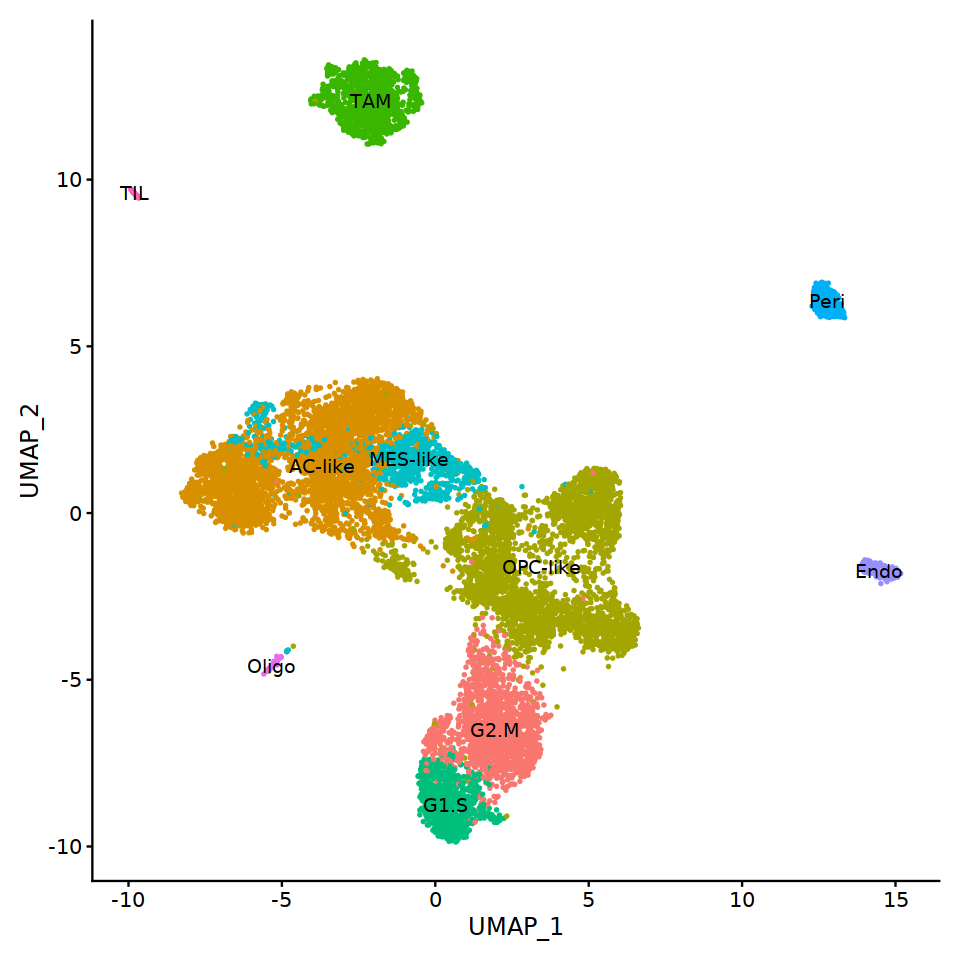

In [ ]:
# Yuan 2018
reference.list[[1]]  <- RenameIdents(reference.list[[1]],
                     `0` = "G2.M", 
                     `1` = "AC-like", 
                     `2` = "AC-like", 
                     `3` = "OPC-like",
                     `4` = "TAM",
                     `5` = "AC-like",
                     `6` = "OPC-like",
                     `7` = "G1.S", 
                     `8` = "OPC-like",
                     `9` = "OPC-like", 
                     `10` = "MES-like", 
                     `11` = "MES-like", 
                     `12` = "Peri",
                     `13` = "Endo",
                     `14` = "MES-like",
                     `15` = "AC-like",
                     `16` = "Oligo", 
                     `17` = "TIL"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[1]] , label = T, pt.size = 0.5) + NoLegend()

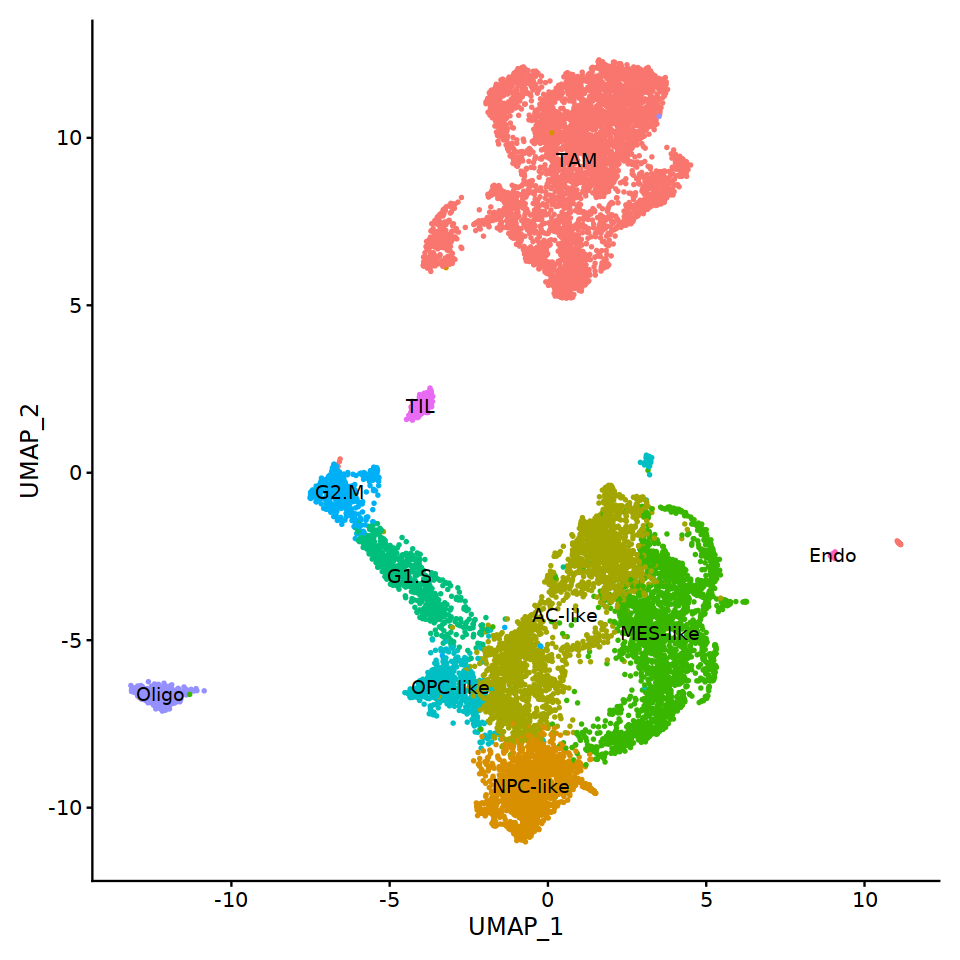

In [ ]:
# Neftel 2019 10x
reference.list[[2]]  <- RenameIdents(reference.list[[2]],
                     `0` = "TAM", 
                     `1` = "NPC-like", 
                     `2` = "AC-like", 
                     `3` = "AC-like",
                     `4` = "MES-like",
                     `5` = "TAM",
                     `6` = "MES-like",
                     `7` = "G1.S", 
                     `8` = "OPC-like",
                     `9` = "TAM", 
                     `10` = "TAM", 
                     `11` = "TAM", 
                     `12` = "G2.M",
                     `13` = "Oligo",
                     `14` = "MES-like",
                     `15` = "TAM",
                     `16` = "TAM", 
                     `17` = "TIL",
                     `18` = "AC-like",
                     `19` = "MES-like",
                     `20` = "Endo",
                     `21` = "TAM"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[2]] , label = T, pt.size = 0.5) + NoLegend()

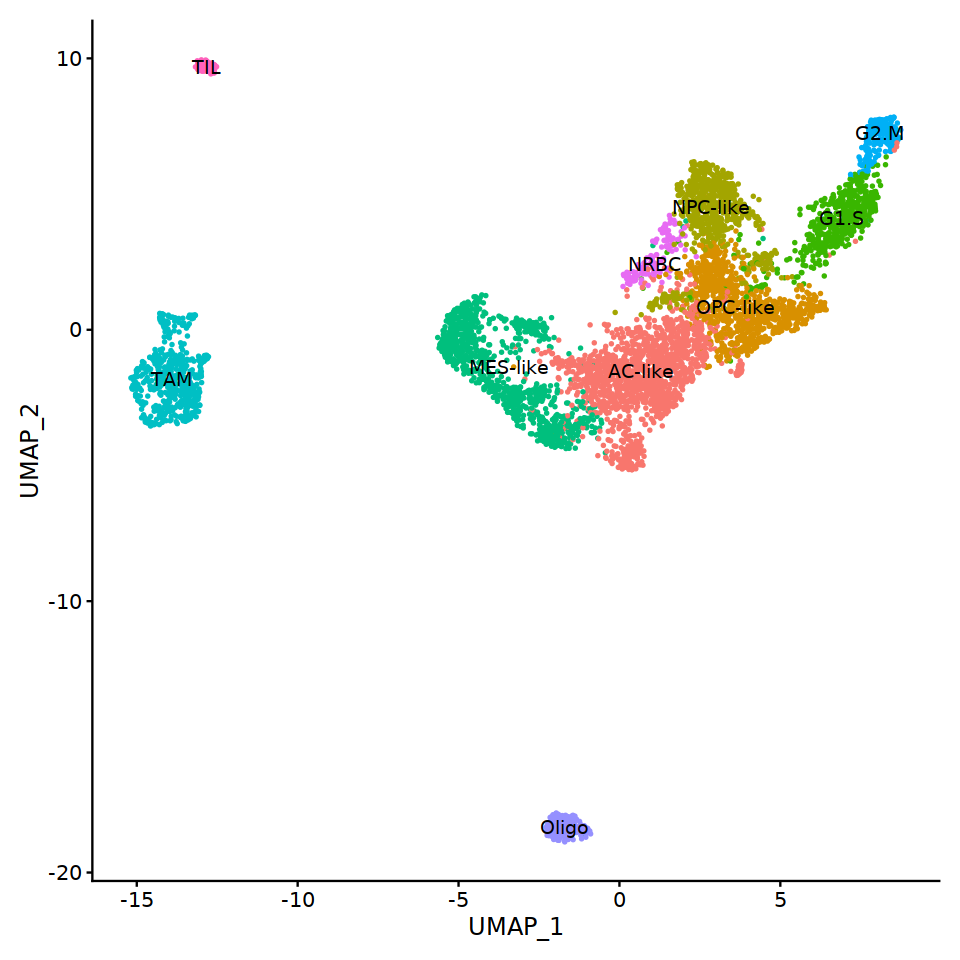

In [ ]:
# Neftel 2019 smart
reference.list[[3]]  <- RenameIdents(reference.list[[3]],
                     `0` = "AC-like", 
                     `1` = "OPC-like", 
                     `2` = "NPC-like", 
                     `3` = "G1.S",
                     `4` = "MES-like",
                     `5` = "TAM",
                     `6` = "MES-like",
                     `7` = "G2.M", 
                     `8` = "Oligo",
                     `9` = "AC-like", 
                     `10` = "NRBC", 
                     `11` = "NPC-like", 
                     `12` = "MES-like",
                     `13` = "TIL",
                     `14` = "TAM"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[3]] , label = T, pt.size = 0.5) + NoLegend()

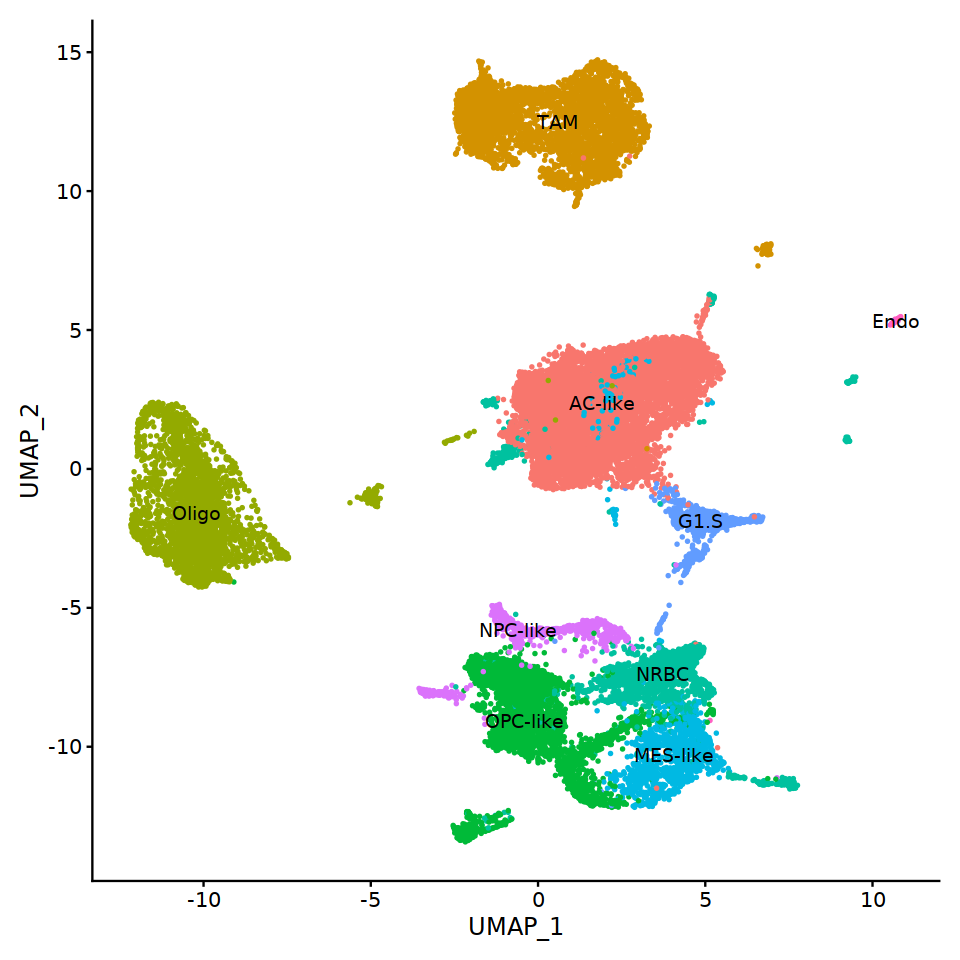

In [ ]:
# Wang 2019
reference.list[[4]]  <- RenameIdents(reference.list[[4]],
                     `0` = "AC-like", 
                     `1` = "AC-like", 
                     `2` = "TAM", 
                     `3` = "TAM",
                     `4` = "Oligo",
                     `5` = "OPC-like",
                     `6` = "NRBC",
                     `7` = "Oligo", 
                     `8` = "MES-like",
                     `9` = "AC-like", 
                     `10` = "OPC-like", 
                     `11` = "OPC-like", 
                     `12` = "G1.S",
                     `13` = "NPC-like",
                     `14` = "OPC-like",
                     `15` = "NRBC",
                     `16` = "Oligo", 
                     `17` = "NRBC",
                     `18` = "NPC-like",
                     `19` = "TAM",
                     `20` = "Endo",
                     `21` = "NRBC", 
                     `22` = "NRBC",
                     `23` = "NRBC"            
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[4]] , label = T, pt.size = 0.5) + NoLegend()

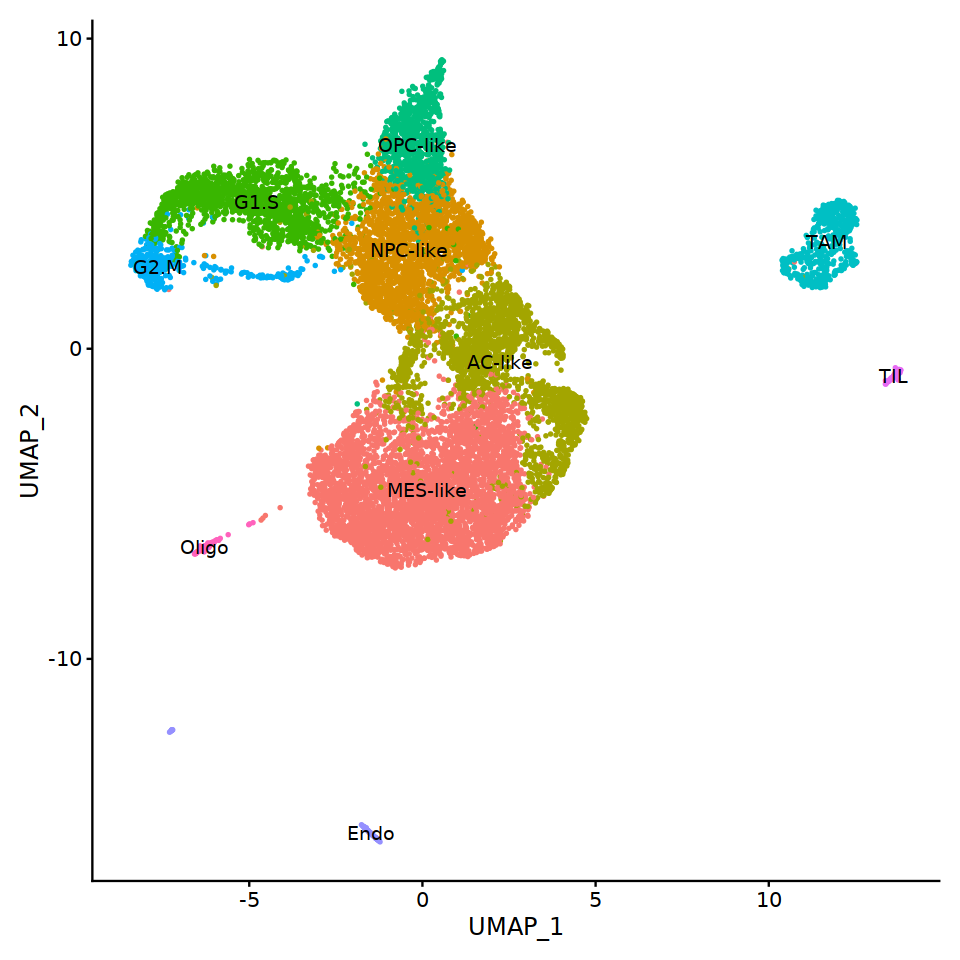

In [ ]:
# Wang 2020
reference.list[[5]]  <- RenameIdents(reference.list[[5]],
                     `0` = "MES-like", 
                     `1` = "MES-like", 
                     `2` = "NPC-like", 
                     `3` = "AC-like",
                     `4` = "G1.S",
                     `5` = "OPC-like",
                     `6` = "NPC-like",
                     `7` = "G1.S", 
                     `8` = "AC-like",
                     `9` = "MES-like", 
                     `10` = "TAM", 
                     `11` = "G2.M", 
                     `12` = "AC-like",
                     `13` = "Endo",
                     `14` = "TIL",
                     `15` = "Oligo"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[5]] , label = T, pt.size = 0.5) + NoLegend()

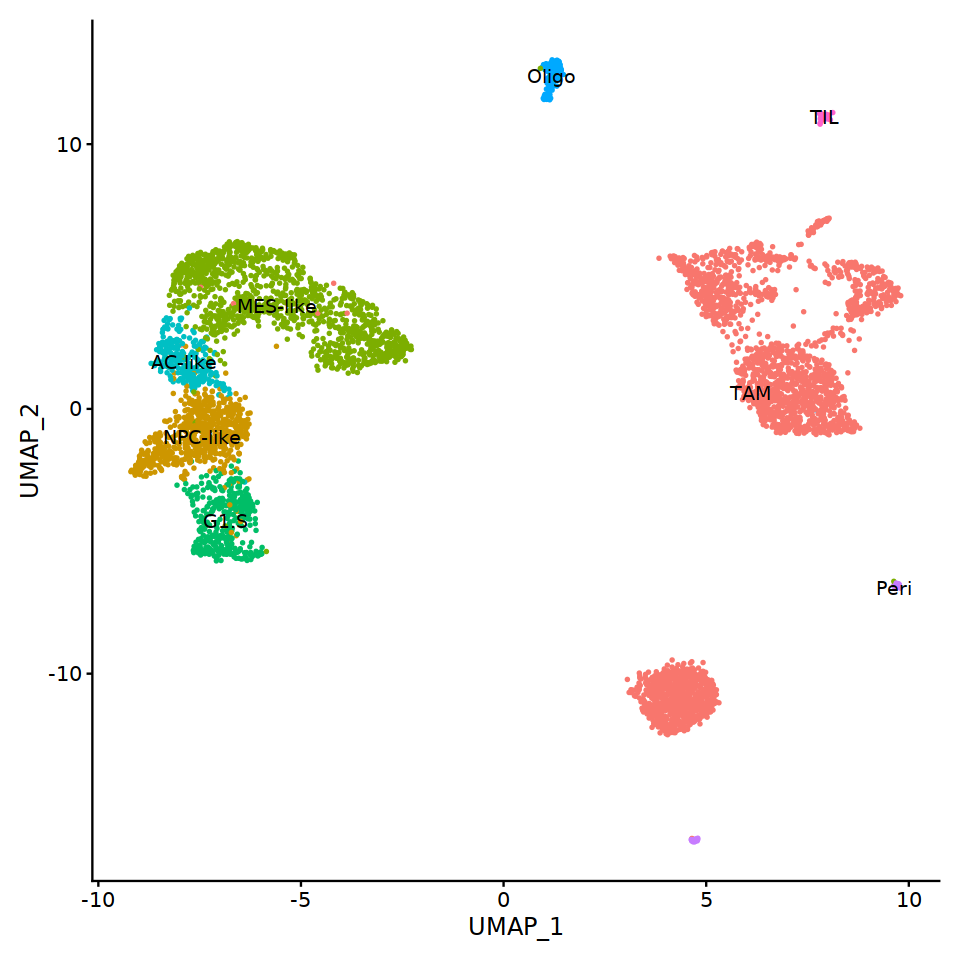

In [ ]:
# Zhao 2020
reference.list[[6]]  <- RenameIdents(reference.list[[6]],
                     `0` = "TAM", 
                     `1` = "TAM", 
                     `2` = "NPC-like", 
                     `3` = "TAM",
                     `4` = "MES-like",
                     `5` = "MES-like",
                     `6` = "G1.S",
                     `7` = "MES-like", 
                     `8` = "AC-like",
                     `9` = "TAM", 
                     `10` = "TAM", 
                     `11` = "Oligo", 
                     `12` = "Peri",
                     `13` = "TIL"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[6]] , label = T, pt.size = 0.5) + NoLegend()

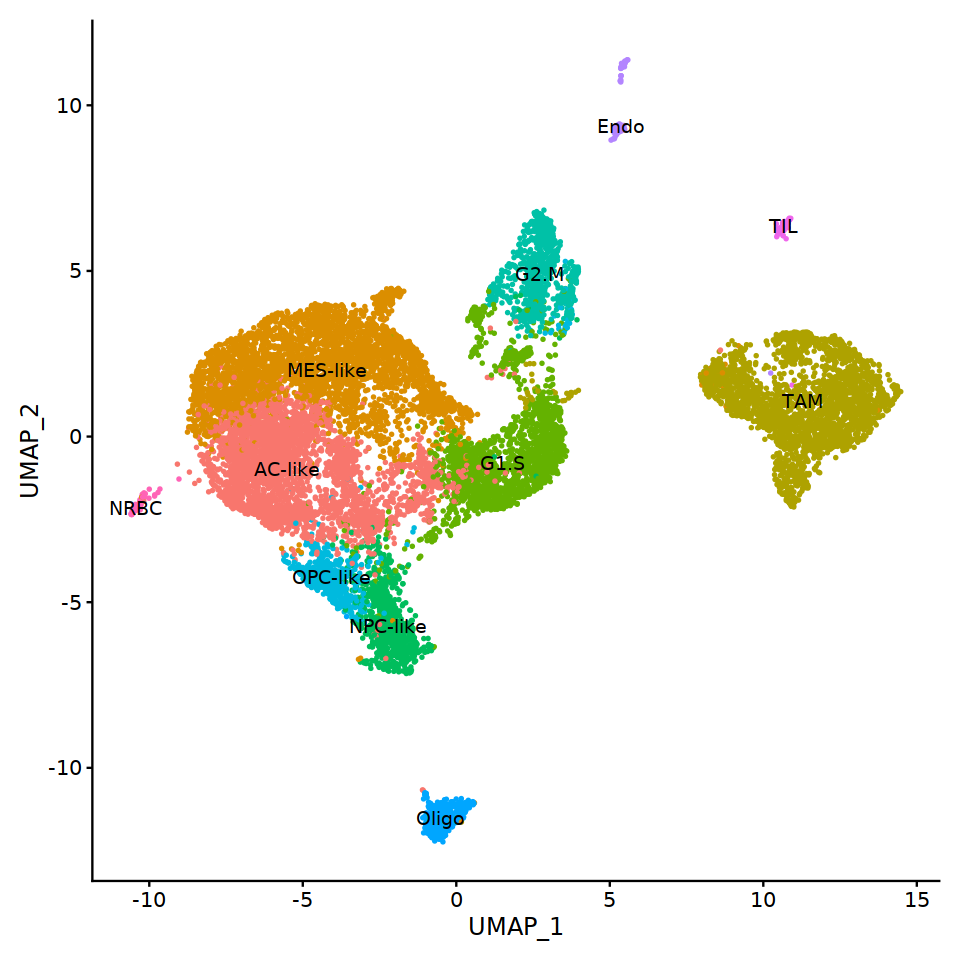

In [ ]:
# Bhaduri 2020
reference.list[[7]]  <- RenameIdents(reference.list[[7]],
                     `0` = "AC-like", 
                     `1` = "MES-like", 
                     `2` = "MES-like", 
                     `3` = "TAM",
                     `4` = "MES-like",
                     `5` = "G1.S",
                     `6` = "NPC-like",
                     `7` = "AC-like", 
                     `8` = "G2.M",
                     `9` = "G1.S", 
                     `10` = "TAM", 
                     `11` = "AC-like", 
                     `12` = "OPC-like",
                     `13` = "TAM",
                     `14` = "Oligo",
                     `15` = "TAM",
                     `16` = "Endo", 
                     `17` = "AC-like",
                     `18` = "G1.S",
                     `19` = "G1.S",
                     `20` = "TIL",
                     `21` = "NRBC"      
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[7]] , label = T, pt.size = 0.5) + NoLegend()

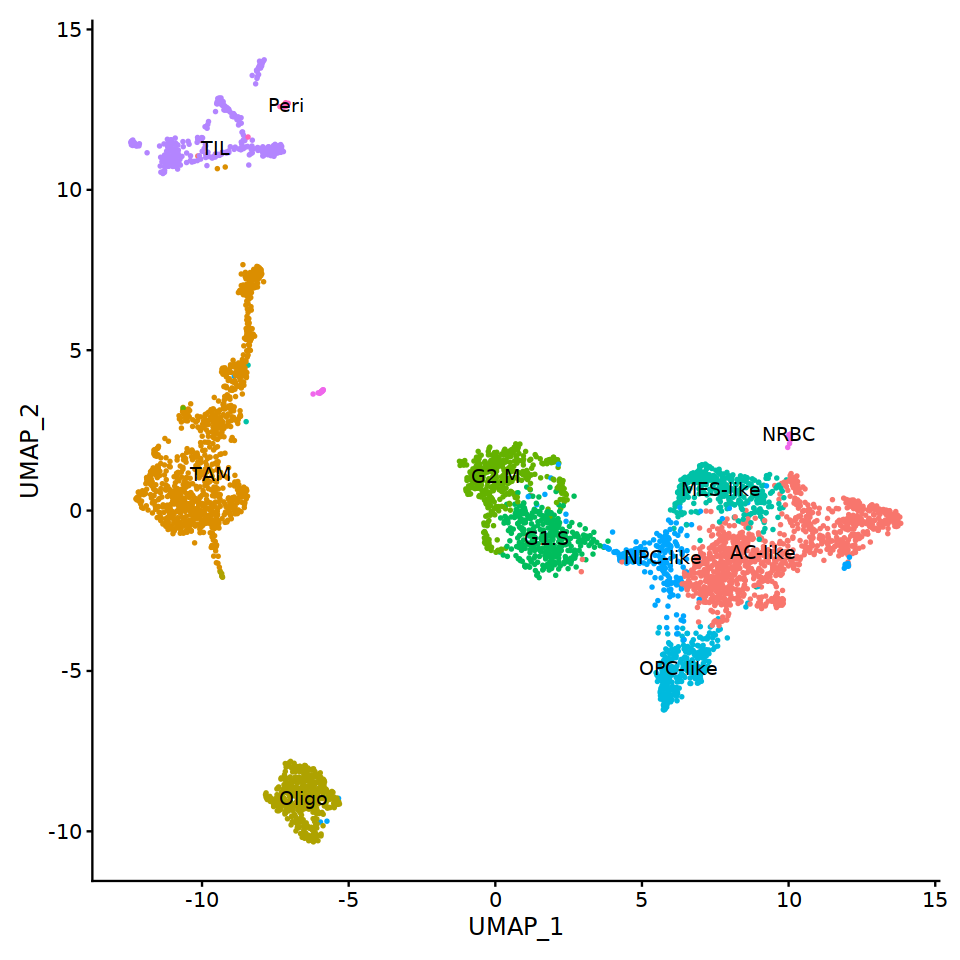

In [ ]:
# Yu 2020
reference.list[[8]]  <- RenameIdents(reference.list[[8]],
                     `0` = "AC-like", 
                     `1` = "TAM", 
                     `2` = "Oligo", 
                     `3` = "AC-like",
                     `4` = "G2.M",
                     `5` = "G1.S",
                     `6` = "MES-like",
                     `7` = "OPC-like", 
                     `8` = "TAM",
                     `9` = "NPC-like", 
                     `10` = "TIL", 
                     `11` = "TIL", 
                     `12` = "TAM",
                     `13` = "G2.M",
                     `14` = "NRBC",
                     `15` = "TIL",
                     `16` = "Peri"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[8]] , label = T, pt.size = 0.5) + NoLegend()

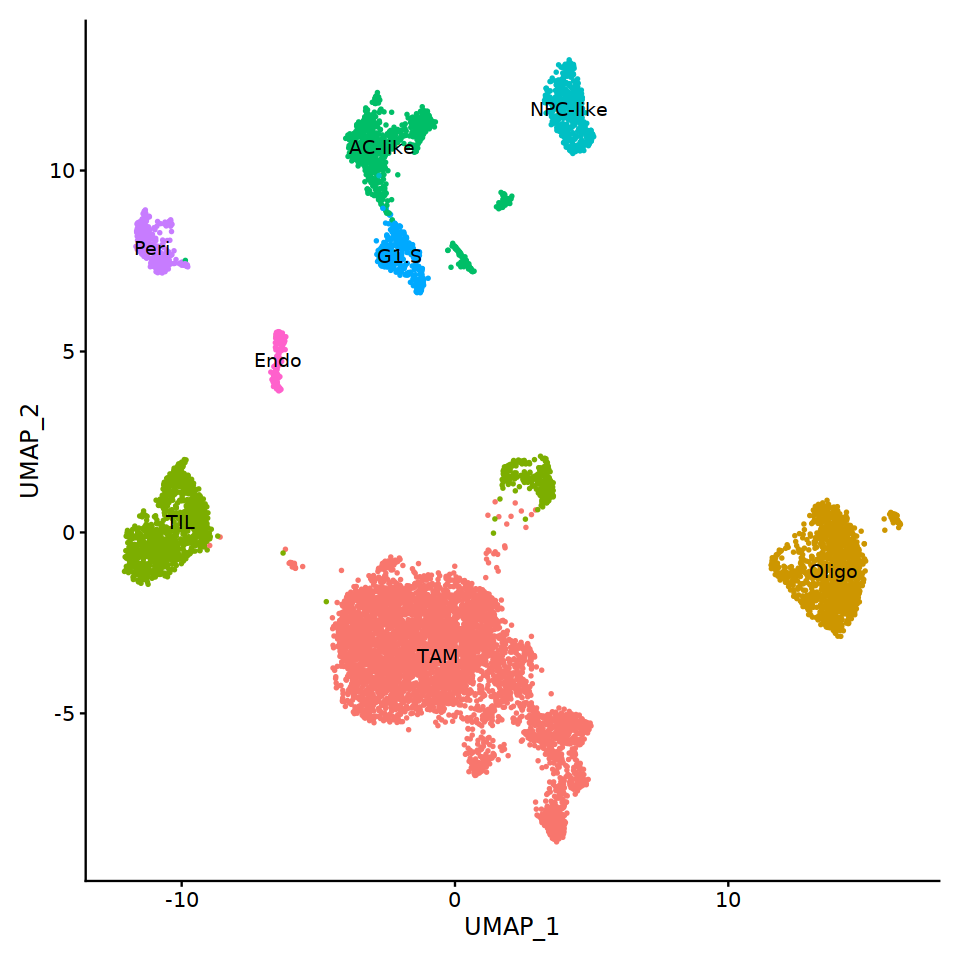

In [ ]:
# Wu 2020
reference.list[[9]]  <- RenameIdents(reference.list[[9]],
                     `0` = "TAM", 
                     `1` = "TAM", 
                     `2` = "Oligo", 
                     `3` = "TIL",
                     `4` = "AC-like",
                     `5` = "TIL",
                     `6` = "NPC-like",
                     `7` = "TAM", 
                     `8` = "TAM",
                     `9` = "G1.S", 
                     `10` = "Peri", 
                     `11` = "TIL", 
                     `12` = "AC-like",
                     `13` = "Endo",
                     `14` = "TAM",
                     `15` = "TAM",
                     `16` = "AC-like",
                     `17` = "AC-like",
                     `18` = "Oligo"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[9]] , label = T, pt.size = 0.5) + NoLegend()

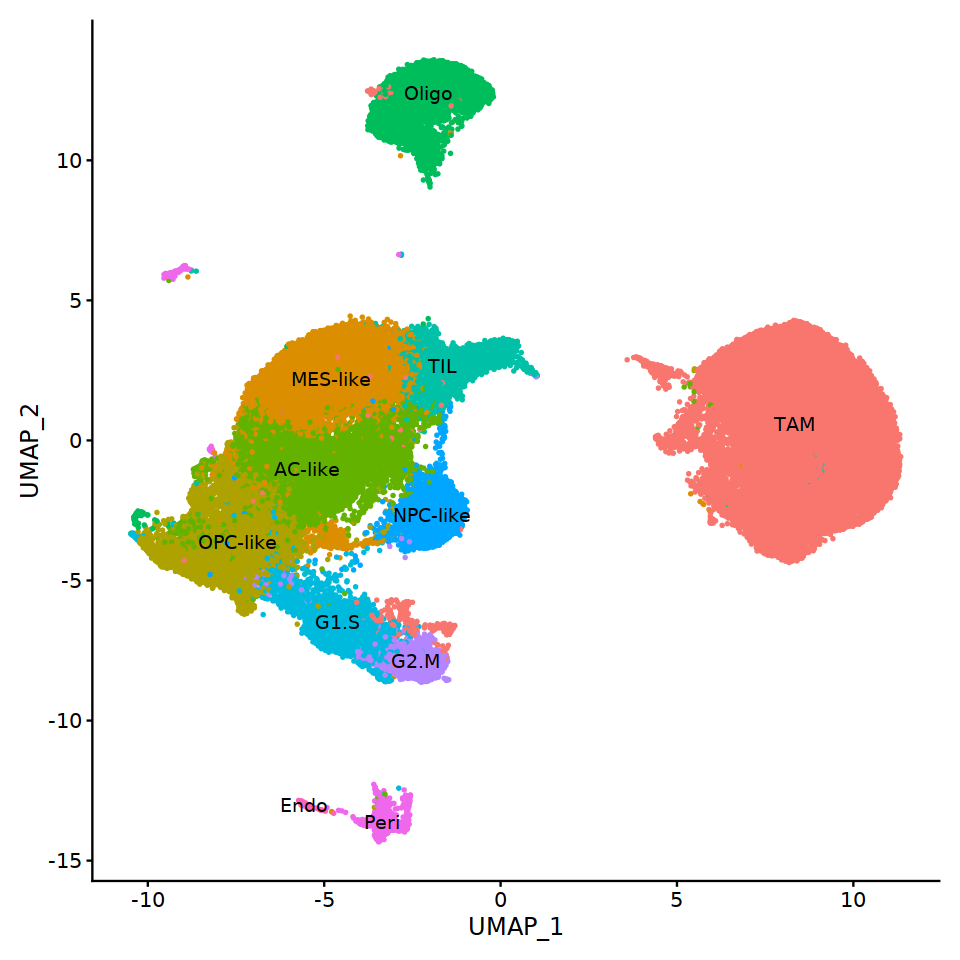

In [ ]:
# Couturier 2018
reference.list[[10]]  <- RenameIdents(reference.list[[10]],
                     `0` = "TAM", 
                     `1` = "MES-like", 
                     `2` = "OPC-like", 
                     `3` = "TAM",
                     `4` = "TAM",
                     `5` = "AC-like",
                     `6` = "Oligo",
                     `7` = "TIL", 
                     `8` = "G1.S",
                     `9` = "NPC-like", 
                     `10` = "AC-like", 
                     `11` = "G2.M", 
                     `12` = "Peri",
                     `13` = "Oligo",
                     `14` = "TAM",
                     `15` = "OPC-like",
                     `16` = "MES-like", 
                     `17` = "TAM",
                     `18` = "TAM",
                     `19` = "G1.S",
                     `20` = "Peri",
                     `21` = "Endo", 
                     `22` = "TIL",
                     `23` = "AC-like",
                     `24` = "TAM"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[10]] , label = T, pt.size = 0.5) + NoLegend()

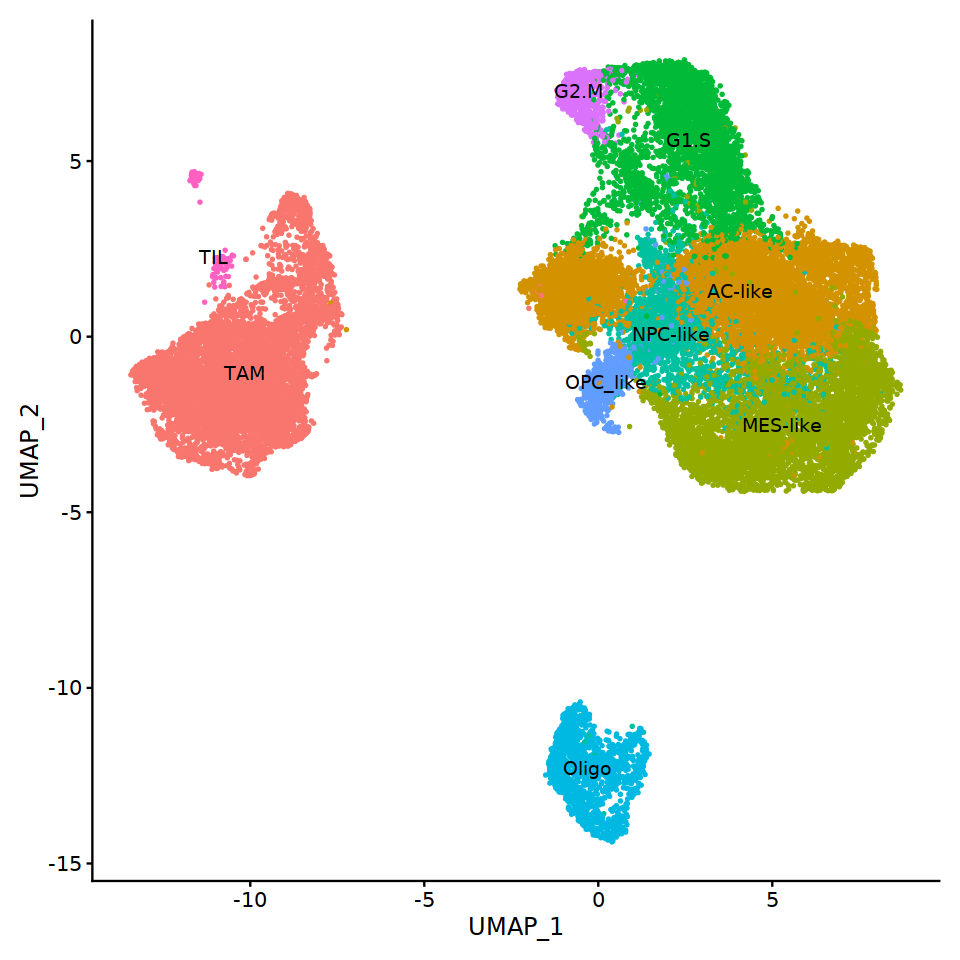

In [ ]:
# Johnson 2020
reference.list[[11]]  <- RenameIdents(reference.list[[11]],
                     `0` = "TAM", 
                     `1` = "AC-like", 
                     `2` = "MES-like", 
                     `3` = "G1.S",
                     `4` = "MES-like",
                     `5` = "AC-like",
                     `6` = "NPC-like",
                     `7` = "Oligo", 
                     `8` = "TAM",
                     `9` = "AC-like", 
                     `10` = "OPC_like", 
                     `11` = "G2.M", 
                     `12` = "G1.S",
                     `13` = "NPC-like",
                     `14` = "TAM",
                     `15` = "TIL",
                     `16` = "TAM"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[11]] , label = T, pt.size = 0.5) + NoLegend()

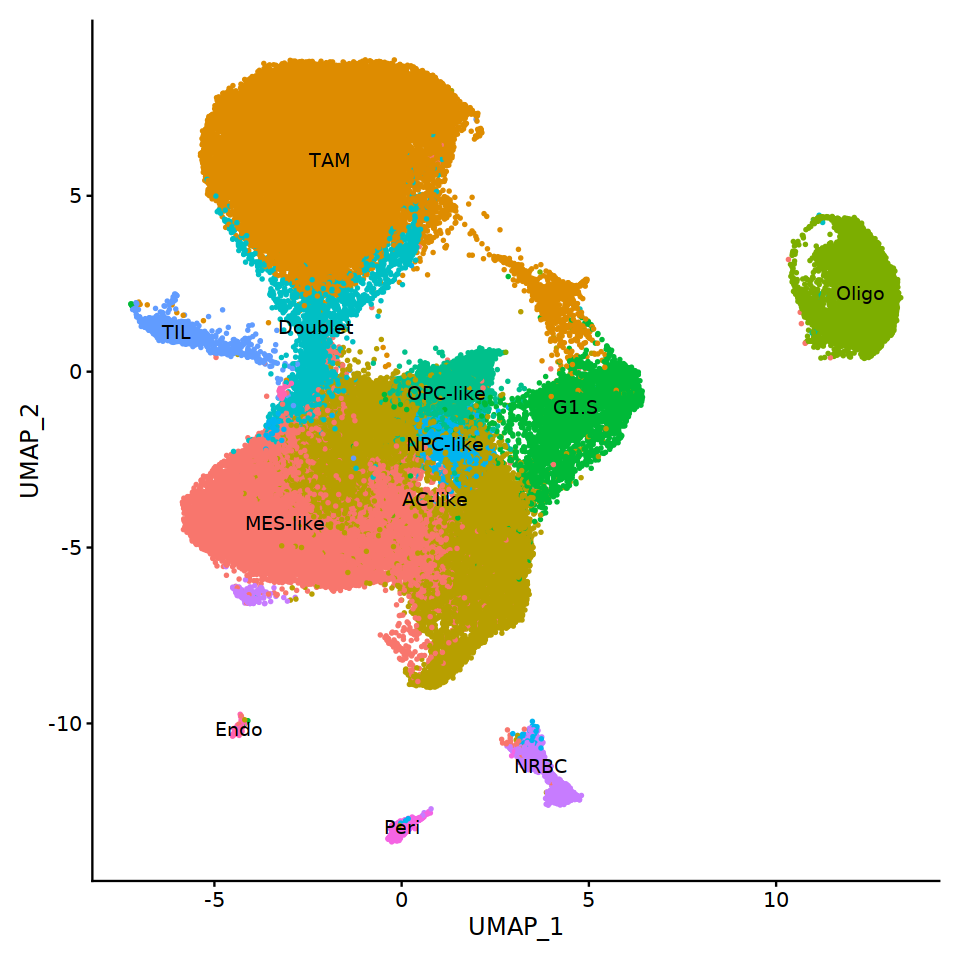

In [ ]:
# Richards 2021
reference.list[[12]]  <- RenameIdents(reference.list[[12]],
                     `0` = "MES-like", 
                     `1` = "TAM", 
                     `2` = "AC-like", 
                     `3` = "AC-like",
                     `4` = "TAM",
                     `5` = "MES-like",
                     `6` = "Oligo",
                     `7` = "TAM", 
                     `8` = "G1.S",
                     `9` = "TAM", 
                     `10` = "OPC-like", 
                     `11` = "Doublet", 
                     `12` = "TAM",
                     `13` = "NPC-like",
                     `14` = "AC-like",
                     `15` = "TIL",
                     `16` = "NRBC", 
                     `17` = "Peri",
                     `18` = "MES-like",
                     `19` = "Oligo",
                     `20` = "Endo",
                     `21` = "NRBC",
                     `22` = "MES-like", 
                     `23` = "NPC-like",
                     `24` = "TAM"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[12]] , label = T, pt.size = 0.5) + NoLegend()

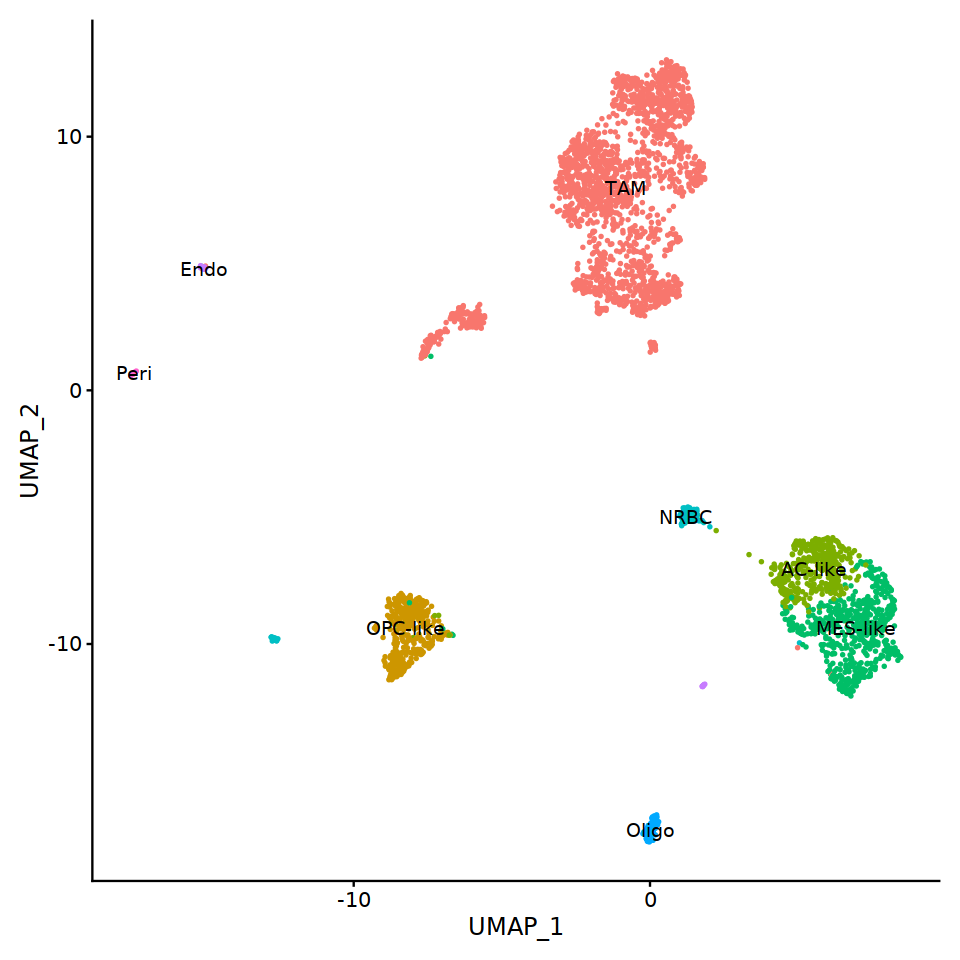

In [ ]:
# Darmanis 2017
reference.list[[13]]  <- RenameIdents(reference.list[[13]],
                     `0` = "TAM", 
                     `1` = "TAM", 
                     `2` = "TAM", 
                     `3` = "OPC-like",
                     `4` = "AC-like",
                     `5` = "MES-like",
                     `6` = "MES-like",
                     `7` = "TAM", 
                     `8` = "TAM",
                     `9` = "NRBC", 
                     `10` = "Oligo", 
                     `11` = "TAM", 
                     `12` = "Endo",
                     `13` = "NRBC",
                     `14` = "Peri"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[13]] , label = T, pt.size = 0.5) + NoLegend()

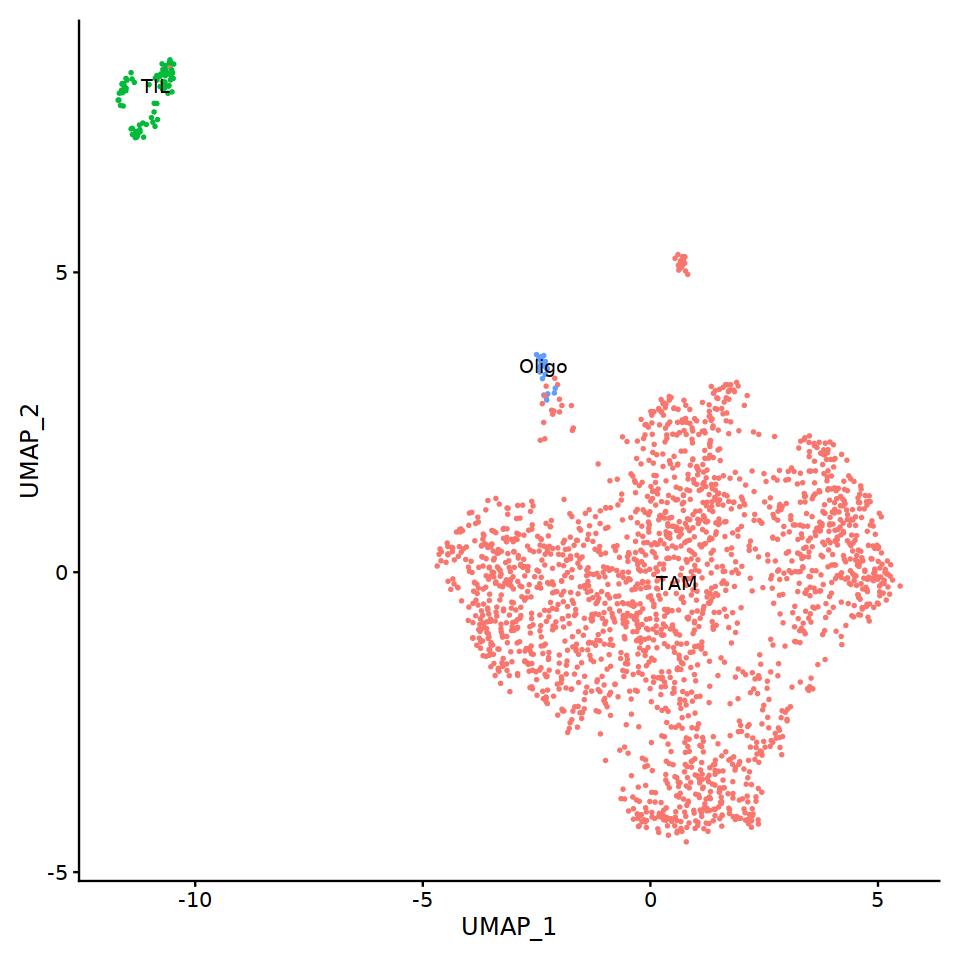

In [ ]:
# Sankowski 2019
reference.list[[14]]  <- RenameIdents(reference.list[[14]],
                     `0` = "TAM", 
                     `1` = "TAM", 
                     `2` = "TAM", 
                     `3` = "TAM",
                     `4` = "TAM",
                     `5` = "TIL",
                     `6` = "Oligo",
                     `7` = "TAM"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[14]] , label = T, pt.size = 0.5) + NoLegend()

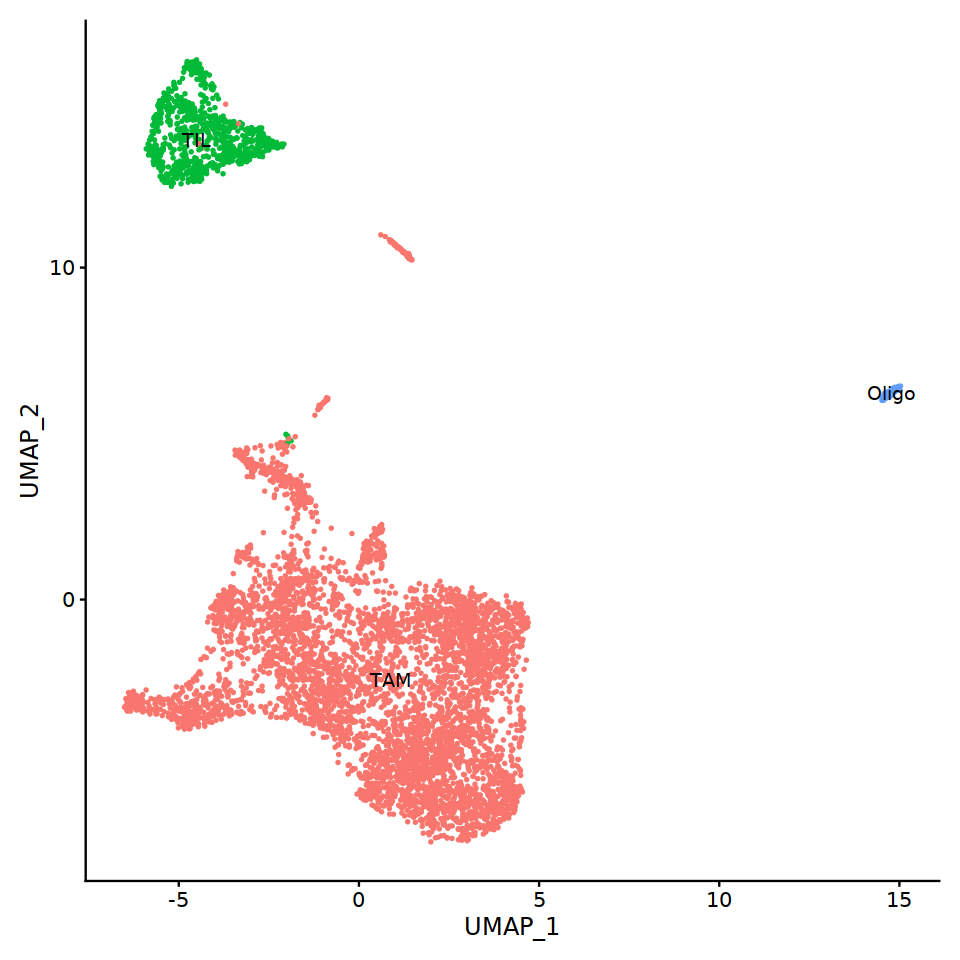

In [ ]:
# Goswami 2019
reference.list[[15]]  <- RenameIdents(reference.list[[15]],
                     `0` = "TAM", 
                     `1` = "TAM", 
                     `2` = "TAM", 
                     `3` = "TAM",
                     `4` = "TIL",
                     `5` = "TAM",
                     `6` = "TAM",
                     `7` = "TAM", 
                     `8` = "TAM",
                     `9` = "TAM", 
                     `10` = "TAM", 
                     `11` = "Oligo", 
                     `12` = "TIL",
                     `13` = "TAM"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[15]] , label = T, pt.size = 0.5) + NoLegend()

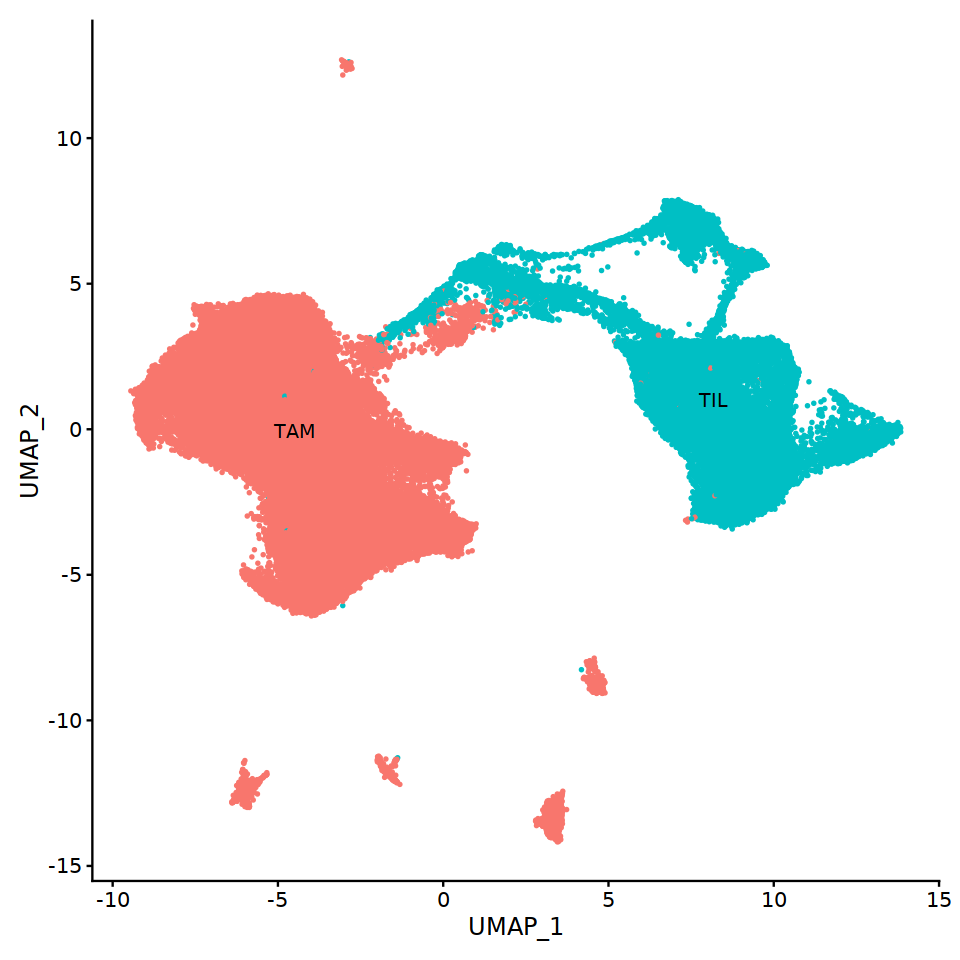

In [ ]:
# Pombo 2021
reference.list[[16]]  <- RenameIdents(reference.list[[16]],
                     `0` = "TAM", 
                     `1` = "TIL", 
                     `2` = "TAM", 
                     `3` = "TIL",
                     `4` = "TAM",
                     `5` = "TAM",
                     `6` = "TAM",
                     `7` = "TAM", 
                     `8` = "TAM",
                     `9` = "TIL", 
                     `10` = "TIL", 
                     `11` = "TIL", 
                     `12` = "TAM",
                     `13` = "TIL",
                     `14` = "TAM",
                     `15` = "TAM",
                     `16` = "TIL", 
                     `17` = "TAM",
                     `18` = "TAM",
                     `19` = "TIL",
                     `20` = "TAM", 
                     `21` = "TAM",
                     `22` = "TAM",
                     `23` = "TAM",
                     `24` = "TAM"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[16]] , label = T, pt.size = 0.5) + NoLegend()

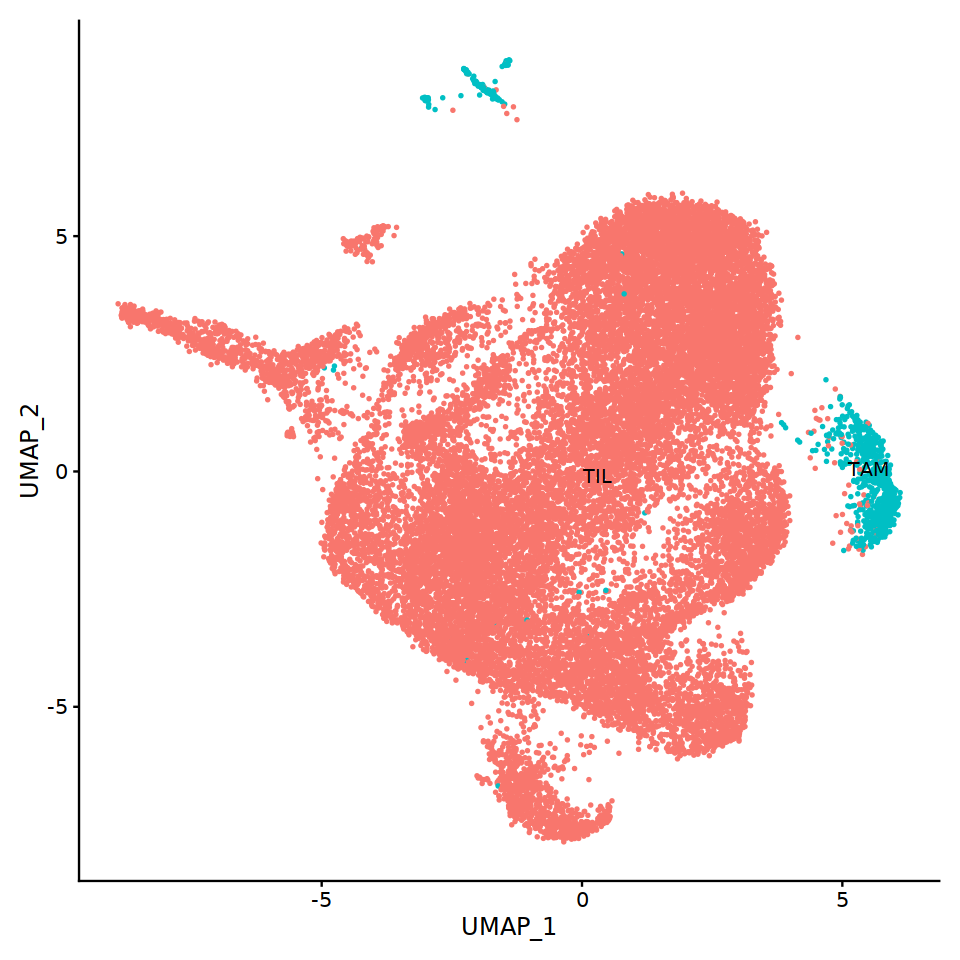

In [ ]:
# Mathewson 2021
reference.list[[17]]  <- RenameIdents(reference.list[[17]],
                     `0` = "TIL", 
                     `1` = "TIL", 
                     `2` = "TIL", 
                     `3` = "TIL",
                     `4` = "TIL",
                     `5` = "TIL",
                     `6` = "TIL",
                     `7` = "TIL", 
                     `8` = "TIL",
                     `9` = "TIL", 
                     `10` = "TIL", 
                     `11` = "TIL", 
                     `12` = "TAM",
                     `13` = "TAM",
                     `14` = "TIL"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[17]] , label = T, pt.size = 0.5) + NoLegend()

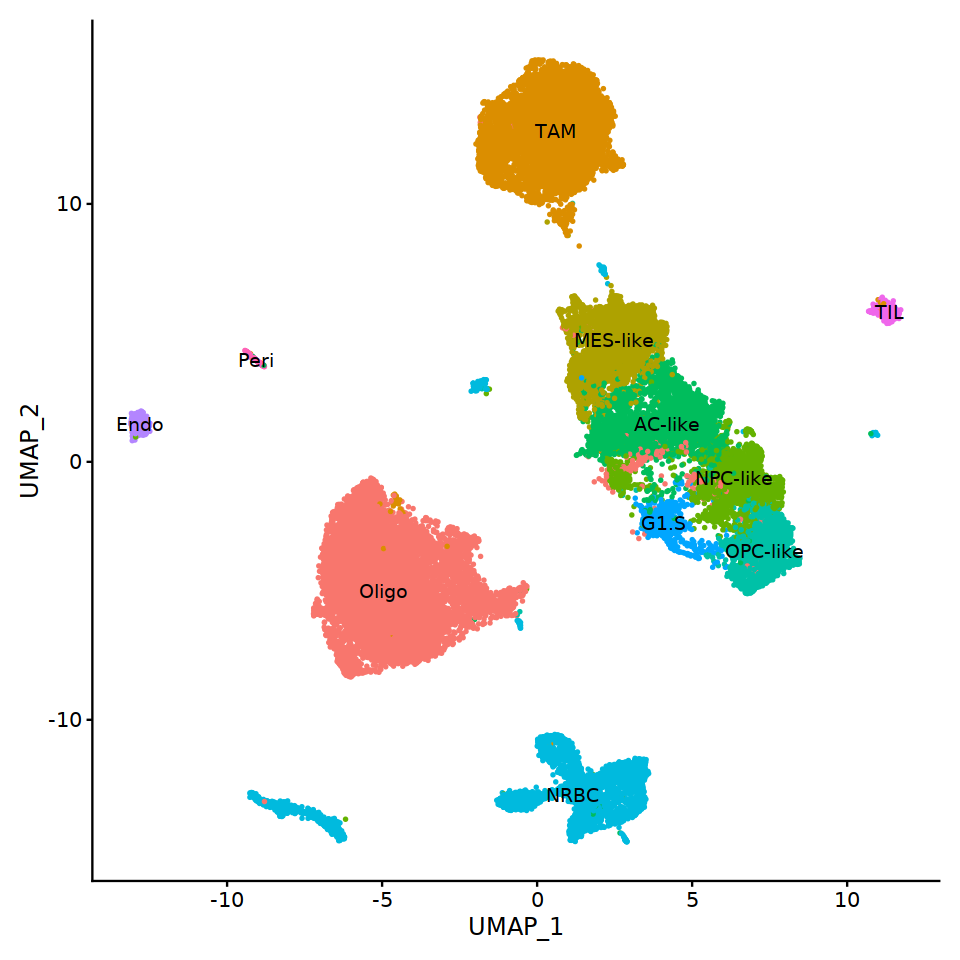

In [ ]:
# Ruiz 2021
reference.list[[18]]  <- RenameIdents(reference.list[[18]],
                     `0` = "Oligo", 
                     `1` = "TAM", 
                     `2` = "MES-like", 
                     `3` = "Oligo",
                     `4` = "NPC-like",
                     `5` = "AC-like",
                     `6` = "OPC-like",
                     `7` = "NRBC", 
                     `8` = "AC-like",
                     `9` = "TAM", 
                     `10` = "Oligo", 
                     `11` = "NRBC", 
                     `12` = "TAM",
                     `13` = "G1.S",
                     `14` = "NRBC",
                     `15` = "NRBC",
                     `16` = "Oligo", 
                     `17` = "Oligo",
                     `18` = "Endo",
                     `19` = "TIL",
                     `20` = "Oligo", 
                     `21` = "NPC-like",
                     `22` = "TAM",
                     `23` = "Oligo",
                     `24` = "Peri",
                     `25` = "NRBC", 
                     `26` = "NPC-like",
                     `27` = "MES-like",
                     `28` = "NRBC",
                     `29` = "NPC-like",
                     `30` = "NRBC",
                     `31` = "NRBC"
)
options(repr.plot.height = 8, repr.plot.width = 8)
DimPlot(reference.list[[18]] , label = T, pt.size = 0.5) + NoLegend()

In [ ]:
datalist = list()

for(i in 1:length(reference.list)){
    df <- as.data.frame(Idents(reference.list[[i]])) 
    datalist[[i]] <- df   
}

celltypes = do.call(rbind, datalist) %>% `colnames<-` ('celltype_assigned')
celltypes

,celltype_assigned
,<fct>
PJ017_0,MES-like
PJ017_1,G2.M
PJ017_2,TAM
PJ017_3,MES-like
PJ017_4,AC-like
PJ017_5,MES-like
PJ017_6,Peri
PJ017_7,AC-like
PJ017_8,MES-like


In [ ]:
table(celltypes$celltype_assigned)


    G2.M  AC-like OPC-like      TAM     G1.S MES-like     Peri     Endo 
    6386    59690    24372   148127    18987    51504     2415     1568 
   Oligo      TIL NPC-like     NRBC OPC_like  Doublet 
   30973    59673    16577     7872      890     2501 

In [ ]:
write.table(celltypes, 'data/assigned_broad_celltypes_core_GBmap.csv', row.names = TRUE, col.names = TRUE, quote = FALSE, sep = ',')